In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import hypergrad as hg
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
# Helper functions to deal with cuda and double precision
cuda = False
double_precision = False

default_tensor_str = 'torch.cuda' if cuda else 'torch'
default_tensor_str += '.DoubleTensor' if double_precision else '.FloatTensor'
torch.set_default_tensor_type(default_tensor_str)

def frnp(x):
    t = torch.from_numpy(x).cuda() if cuda else torch.from_numpy(x)
    return t if double_precision else t.float()

def tonp(x, cuda=cuda):
    return x.detach().cpu().numpy() if cuda else x.detach().numpy()

In [3]:
# synthetic data generation
seed = 1
n, d = 1000, 20
val_perc = 0.5
np.random.seed(seed)

w_oracle = np.random.randn(d)
x = np.random.randn(n, d)
y = x  @ w_oracle + 0.1 * np.random.randn(n)
y = (y > 0.).astype(float) # binary classification output

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=val_perc)
x_train, x_val, y_train, y_val = frnp(x_train), frnp(x_val), frnp(y_train), frnp(y_val)


In [4]:
# problem definition
hparams = [torch.ones(d).requires_grad_(True)]
inner_lr = 0.1

val_losses = []
def val_loss(params, hparams, x=x_val, y=y_val):
    val_loss = F.binary_cross_entropy_with_logits(x @ params[0], y)
    val_losses.append(tonp(val_loss))
    return val_loss

inner_losses = []
def fp_map(params, hparams):
    w = params[0]
    loss = F.binary_cross_entropy_with_logits(x_train @ w, y_train) +\
           0.5 * (w.unsqueeze(0) @ torch.diag(hparams[0]) @ w.unsqueeze(1)).sum()
    inner_losses.append(tonp(loss))
    return [params[0] - inner_lr*torch.autograd.grad(loss, params, create_graph=True)[0]]

t=0: inner loss = 0.6931472420692444
t=10: inner loss = 0.6285591125488281
t=20: inner loss = 0.6243906021118164
t=30: inner loss = 0.6241106390953064
t=40: inner loss = 0.6240913271903992
t=50: inner loss = 0.6240900754928589
t=60: inner loss = 0.6240900754928589
t=70: inner loss = 0.6240899562835693
t=80: inner loss = 0.6240898966789246
t=90: inner loss = 0.6240898370742798
t=99: inner loss = 0.6240898370742798
reverse_unroll - reverse (should be 0): 0.0


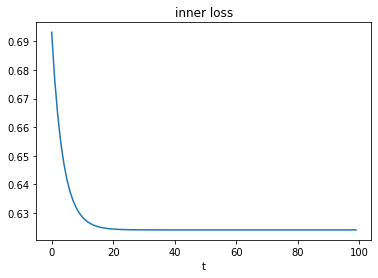

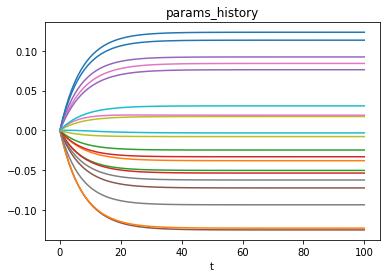

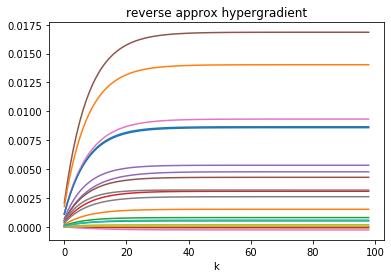

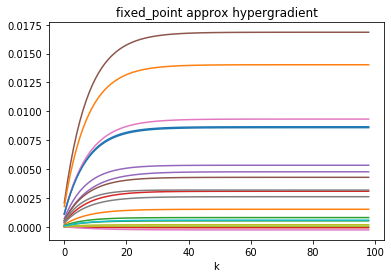

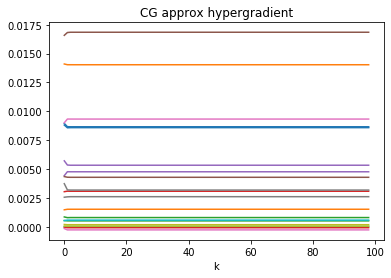

In [5]:
# inner optimization
T = 100

inner_losses = []
params_history = [[torch.zeros(d).requires_grad_(True)]]
for t in range(T):
    new_params = fp_map(params_history[-1], hparams)
    params_history.append(new_params)

    if t % 10 == 0 or t == T-1:
        print("t={}: inner loss = {}".format(t, inner_losses[-1]))


plt.title('inner loss')
plt.xlabel('t')
plt.plot(inner_losses)
plt.show()

plt.title('params_history')
plt.xlabel('t')
plt.plot([tonp(p[0]) for p in params_history])
plt.show()

# hypergradients comparison
K = T
final_params = params_history[-1]
for hg_name, hg_alg in (('reverse', hg.reverse),
                        ('fixed_point', hg.fixed_point),
                        ('CG', hg.CG)):
    h_grads = []
    for k in range(1, K):
        if hg_name == 'reverse':
            h_grad = hg.reverse(params_history[-k-1:], hparams, [fp_map]*k, val_loss)
        else:
            h_grad = hg_alg(final_params, hparams, k, fp_map, val_loss)

        h_grads.append(tonp(h_grad[0]))

    plt.title(hg_name + ' approx hypergradient')
    plt.xlabel('k')
    plt.plot(h_grads)
    #plt.legend()
    plt.show()

# check that reverse K=T and reverse_unroll have same output
h_grad_reverse_unroll = hg.reverse_unroll(params_history[-1], hparams, val_loss)
h_grad_reverse = hg.reverse(params_history[-T-1:], hparams, [fp_map]*T, val_loss)
h_grad_diff = torch.sum(h_grad_reverse_unroll[0] - h_grad_reverse[0]).item()
print('reverse_unroll - reverse (should be 0):', h_grad_diff)

o_step=0(1.81e-01s) val loss=0.5743989944458008 
o_step=10(1.85e-01s) val loss=0.5337678790092468 
o_step=20(1.25e-01s) val loss=0.3615218698978424 
o_step=30(2.40e-01s) val loss=0.3225042521953583 
o_step=40(2.24e-01s) val loss=0.2987646162509918 
o_step=50(1.28e-01s) val loss=0.2944669723510742 
o_step=60(1.28e-01s) val loss=0.2905733585357666 
o_step=70(1.26e-01s) val loss=0.2885856032371521 
o_step=80(1.23e-01s) val loss=0.2871982753276825 
o_step=90(1.27e-01s) val loss=0.28584417700767517 
o_step=100(1.23e-01s) val loss=0.2853544056415558 
o_step=110(1.24e-01s) val loss=0.284612774848938 
o_step=120(1.99e-01s) val loss=0.2834946811199188 
o_step=130(1.23e-01s) val loss=0.2829788625240326 
o_step=140(1.25e-01s) val loss=0.2827620506286621 
o_step=150(1.26e-01s) val loss=0.2824600040912628 
o_step=160(1.23e-01s) val loss=0.28203490376472473 
o_step=170(1.28e-01s) val loss=0.2817196547985077 
o_step=180(2.39e-01s) val loss=0.2817072570323944 
o_step=190(1.27e-01s) val loss=0.28168922

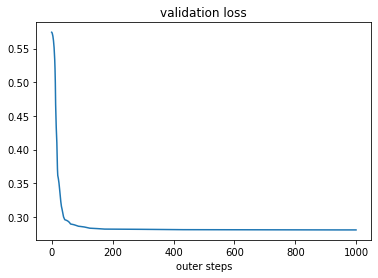

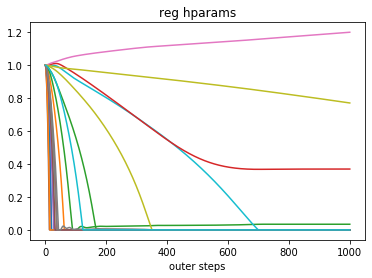

In [6]:
#HPO
import time
outer_steps = 1000
eval_interval = 10
T, K = 100, 10

hparams = [torch.ones(d).requires_grad_(True)]
outer_opt = torch.optim.SGD(lr=1., momentum=.9, params=hparams)
total_time, val_losses = 0,  []
hparams_history = [tonp(hparams[0].clone())]
for o_step in range(outer_steps):

    step_start_time = time.time()

    inner_losses = []
    params_history = [[torch.zeros(d).requires_grad_(True)]]
    for t in range(T):
        new_params = fp_map(params_history[-1], hparams)
        params_history.append(new_params)

    outer_opt.zero_grad()
    #hg.reverse_unroll(params_history[-1], hparams, val_loss, set_grad=True)
    hg.reverse(params_history[-K-1:], hparams, [fp_map]*(K), val_loss, set_grad=True)
    #hg.CG(params_history[-1], hparams, K, fp_map, val_loss, set_grad=True)
    #hg.fixed_point(params_history[-1], hparams, K, fp_map, val_loss, set_grad=True)
    outer_opt.step()
    hparams[0].data.clamp_(min=1e-8)

    step_time = time.time()-step_start_time
    total_time +=step_time
    hparams_history.append(tonp(hparams[0].clone()))

    if o_step % eval_interval == 0 or o_step == outer_steps:
        print('o_step={}({:.2e}s) val loss={} '.format(o_step, step_time, val_losses[-1]))

print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
plt.plot(val_losses)
plt.show()

plt.title('reg hparams')
plt.xlabel('outer steps')
plt.plot(hparams_history)
plt.show()


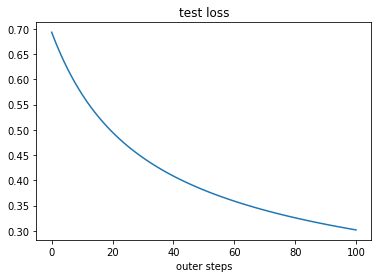

In [7]:
# check test performance
n_test = 1000
x_test = np.random.randn(n_test, d)
y_test = x_test  @ w_oracle + 0.1 * np.random.randn(n_test)
y_test = (y_test > 0.).astype(float) # binary classification output
x_test, y_test = frnp(x_test), frnp(y_test)

test_losses = []
for p in params_history:
    test_losses.append(tonp(val_loss(p, hparams, x=x_test, y=y_test)))

plt.title('test loss')
plt.xlabel('outer steps')
plt.plot(test_losses)
plt.show()